In [66]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *
# for local
TRAIN_DIR = "../data/input/train.csv"
TEST_DIR = "../data/input/test.csv"
SUBMIT_DIR = "../data/output/sample_submission.csv"

# for kaggle notebook
# TRAIN_DIR = "/kaggle/input/icr-identify-age-related-conditions/train.csv"
# TEST_DIR = "/kaggle/input/icr-identify-age-related-conditions/test.csv"
# SUBMIT_DIR = "/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv"

In [67]:
train = pd.read_csv(TRAIN_DIR)
test = pd.read_csv(TEST_DIR)

train["EJ"] = train["EJ"].map({"A":0,"B":1})
test["EJ"] = test["EJ"].map({"A":0,"B":1})

In [68]:
from sklearn.impute import SimpleImputer,KNNImputer
imputer = KNNImputer(n_neighbors=50)

X = train.drop(["Id","Class"],axis=1)
X = imputer.fit_transform(X)
y = train[["Class"]].to_numpy()

X_test = test.drop("Id",axis=1)
X_test = imputer.fit_transform(X_test)

# PCA 

## 2次元

In [69]:
trans_X

,dim_1,dim_2,Class
0,-12649.372390,-1430.238931,1
1,13391.320419,-3461.897363,0
2,-959.364987,-2018.243700,0
3,-12546.710768,431.359272,0
4,-6262.280652,5993.154164,1
...,...,...,...
612,-6636.388805,6754.534745,0
613,-11700.106004,8031.807654,0
614,-8136.713664,-5293.245719,0
615,-12626.471932,-4025.180448,0


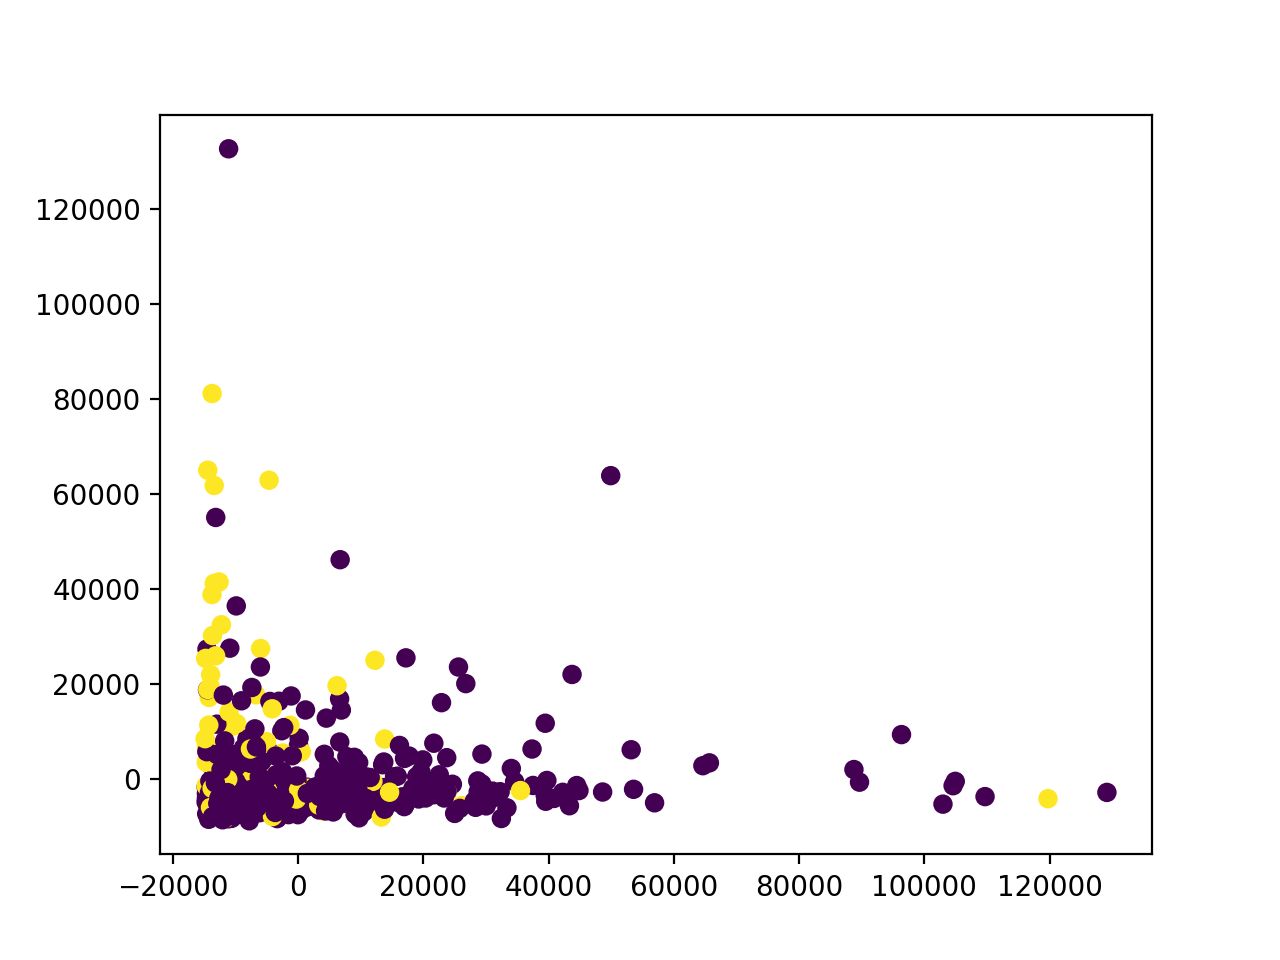

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
trans_X = pca.fit_transform(X)

plt.scatter(trans_X[:,0],trans_X[:,1],c=y)

# plotnine
# trans_X = pd.DataFrame(trans_X,columns=["dim_1","dim_2"])
# trans_X["Class"] = train["Class"]

# print(ggplot(trans_X)+
#       geom_point(aes(x="dim_1",y="dim_2",fill="Class"))
#      )

## 3次元

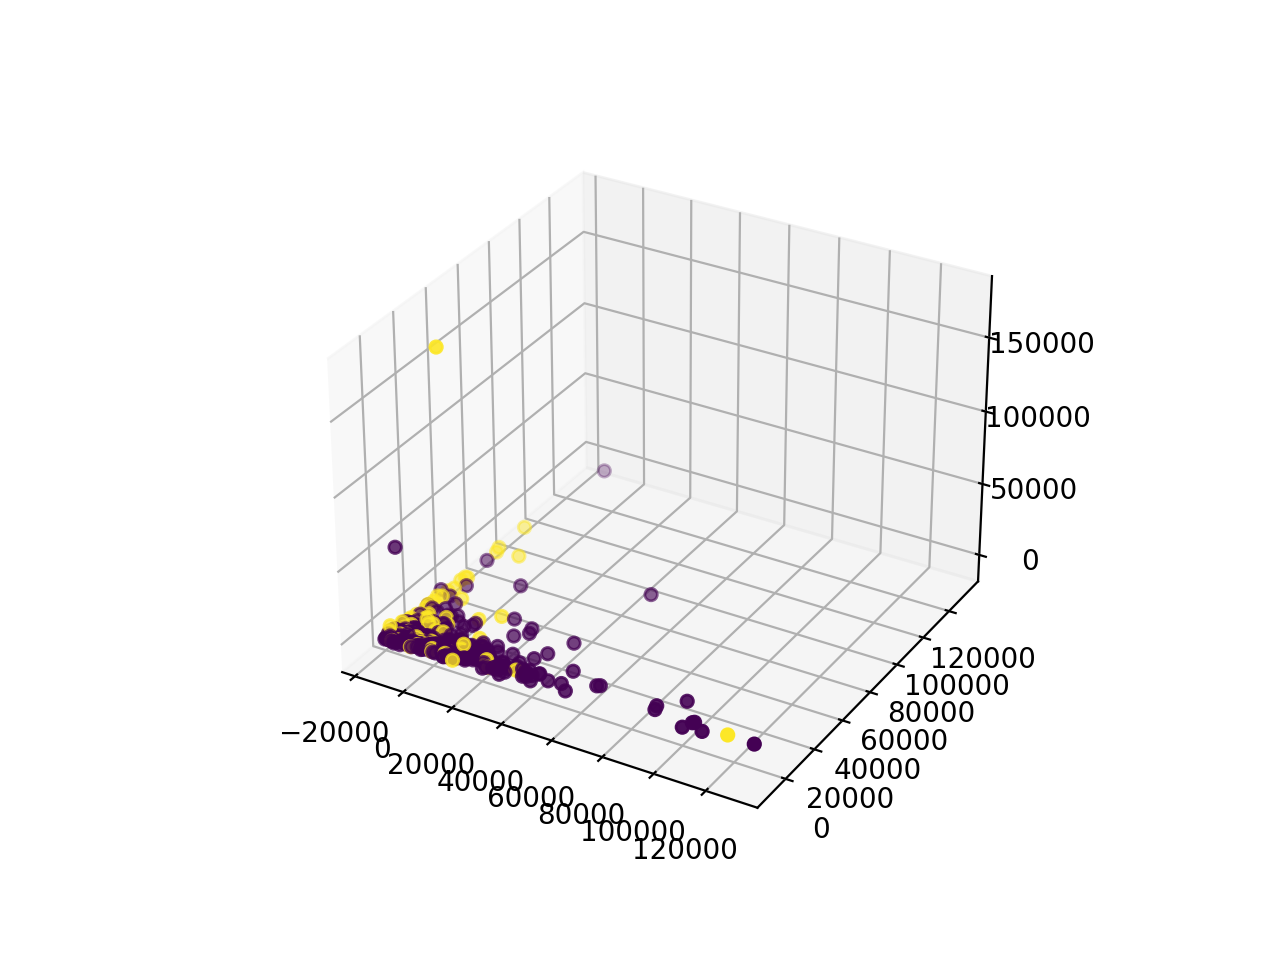

In [71]:
pca = PCA(n_components=3)
trans_X = pca.fit_transform(X)

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(trans_X[:,0],trans_X[:,1],trans_X[:,2],c=y.reshape(-1))
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.show()

## 考察

- 2次元,3次元の圧縮でもプロットが重なってしまって違いがわからない
- 56次元の圧縮だが一部だけ取り出すことで違いが確認できるのか？

# feature selection

ベースラインモデルからfeatue importance を計算

In [72]:
from lightgbm import LGBMClassifier 


params = {'n_estimators': 400, 
          'num_leaves': 16,
          'max_depth': 3,
          'learning_rate': 0.08405720120473595,
          'subsample': 0.3064498908317925,
          # 'colsample/bytree': 0.6588735233587487,
          'reg_lambda': 8.455357407692809}

model = LGBMClassifier(**params)
model.fit(X,y.reshape(-1))
model.feature_importances_


array([162,  48,   9,  67,   2,  76,   9,   3,  48,  25,  37,  33,  93,
         7,   0,  25,  63,  37,   8,  32,  22,  88,  35,  12,  30, 106,
        67,   9,  10,  51, 115,  82, 158,   5,  88,  68,  88,  64,   6,
         0,  48,  62,  44,   2,  27,  72,  77,  87,  45,  39,   1,  27,
         3,  38,  10,  74], dtype=int32)

In [73]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# feature importance とそのラベルを取得
labels = train.drop(["Id","Class"],axis=1).columns
importances = model.feature_importances_

# データフレームに変換+MinMaxScaling
df_importances = pd.DataFrame(importances,index=labels,columns=["importance"])

mmscaler = MinMaxScaler()
df_importances["importance"] = mmscaler.fit_transform(df_importances)


# 特徴量重要度を可視化
# plt.figure(figsize = (10,6))
# plt.barh(y = range(len(importances)), width = importances)
# plt.yticks(ticks = range(len(labels)), labels = labels)
# plt.show()

## 重要度が0.2以上あるものを選択

In [74]:
df_importances.query("importance>0.2").index

Index(['AB', 'AF', 'AM', 'AX', 'BC', 'BN', 'BP', 'BQ', 'CC', 'CD ', 'CR', 'CS',
       'DA', 'DE', 'DI', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE', 'EG', 'EL', 'EP',
       'EU', 'FE', 'FI', 'FL', 'FR', 'FS', 'GH', 'GL'],
      dtype='object')

In [75]:
columns_selected = ['AB', 'AF', 'AM', 'AX', 'BC', 'BN', 'BP', 'BQ', 'CC', 'CD ','CR',
                    'CS','DA', 'DE', 'DI', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE', 'EG', 
                    'EL', 'EP','EU', 'FE', 'FI', 'FL', 'FR', 'FS', 'GH', 'GL']

## 選択した特徴量でモデル構築+交差検証

In [76]:
from sklearn.impute import SimpleImputer,KNNImputer
imputer = KNNImputer(n_neighbors=50)

X_selected = train.drop(["Id","Class"],axis=1)
X_selected = X_selected[columns_selected]
X_selected = imputer.fit_transform(X_selected)
y = train[["Class"]].to_numpy()

X_test_selected = test.drop("Id",axis=1)
X_test_selected = X_test_selected[columns_selected]
X_test_selected = imputer.fit_transform(X_test_selected)

In [77]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold

params = params = {'n_estimators': 400, 
          'num_leaves': 16,
          'max_depth': 3,
          'learning_rate': 0.08405720120473595,
          'subsample': 0.3064498908317925,
          # 'colsample/bytree': 0.6588735233587487,
          'reg_lambda': 8.455357407692809}


model = LGBMClassifier(**params)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
logloss_list = []

for train_index,val_index in skf.split(X_selected,y):
    
    train_X,val_X = X[train_index,:],X[val_index,:]
    train_y,val_y = y[train_index],y[val_index]
    
    model.fit(train_X,train_y.reshape(-1))
    
    pred_proba = model.predict_proba(val_X)
    
    logloss = log_loss(val_y,pred_proba)
    
    logloss_list.append(logloss)
    

cv_score = np.mean(logloss_list)

print(cv_score)
    
    


0.16163843983518433


In [78]:
model = LGBMClassifier(**params)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
logloss_list = []

for train_index,val_index in skf.split(X,y):
    
    train_X,val_X = X[train_index,:],X[val_index,:]
    train_y,val_y = y[train_index],y[val_index]
    
    model.fit(train_X,train_y.reshape(-1))
    
    pred_proba = model.predict_proba(val_X)
    
    logloss = log_loss(val_y,pred_proba)
    
    logloss_list.append(logloss)
    

cv_score = np.mean(logloss_list)

print(cv_score)
    

0.16163843983518433


In [ ]:
X_selcted.sh